# Fairness Sandox

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
# uncomment as needed

# %pip install aif360
# %pip install fairlearn
# %pip install imbalanced-learn
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from numpy import percentile

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Data

### Dataset Class

In [3]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = [],
                 sens_attr = '', has_sens_attr = True,
                 sep = '', synthetic = False):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.has_sens_attr = has_sens_attr
        if has_sens_attr:
            self.sens_attr = sens_attr
        if not synthetic:
            self.df = pd.read_csv(path, sep = sep)

In [4]:
# collection of datasets is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        raise TypeError("Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

### Popular Datasets

In [5]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols_adult = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols_adult = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols_adult, num_cols_adult, sep = ",", sens_attr = 'race')

add_dataset(adult_income)

In [6]:
cat_cols_por = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num_cols_por = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_por", path='Datasets/student-por.csv',
                    cat_cols=cat_cols_por, num_cols=num_cols_por, sep = ";", sens_attr = 'sex'))

### Synthetic Data

In [7]:
from synthetic_data import get_synthetic_data

In [8]:
'''
Parameters:

    n is the total number of examples in the dataset

    num_numerical_feats is number of numerical features
        each numerical feature is drawn from a
        multivariate normal distribution

    means = mean for each numerical features, default is 0 mean
        NOTE: len(means) == num_numerical_feats

    cov_matrix = covariance matrix for numerical features, 
        default is identity matrix
        NOTE: cov_matrix.shape == np.identity(num_numerical_feats).shape

    num_cat_feats is number of categorical features

    cat_levels is an array where each element is the number
        of levels for each categorical feature
        len(cat_levels) = num_cat_feats

    r is the proportion of examples in the minority group
        (1-r) is proportion of examples in majority group

    label_noise is in [0,1]

    diff_dist is true if minority and majority have different
        underlying sampling distributions

    show_vis displays the distribution of outcomes

'''

df_synthetic = get_synthetic_data(n=1000, r = 0.25, num_numerical_feats=3, num_cat_feats=2, 
                                  cat_levels=[2,3], diff_dist=True, label_noise = 0.1)

# add to dictionary of datasets
path_synthetic = 'Datasets/synthetic_data.csv'
df_synthetic.to_csv(path_synthetic)
add_dataset(Dataset('synthetic', path_synthetic, cat_cols=[], num_cols=[], synthetic=True, sens_attr = "sens_feat"))

# EDA + Data Visualizations

Feel free to use any/all of the following EDA functions and/or add your own!

In [9]:
# take a peek at the first few data points
df_synthetic.head()

,num1,num2,num3,cat1,cat2,sens_feat,outcome
0,0.995436,-0.161616,-1.717994,1.0,2.0,1.0,0.0
1,-0.035595,0.501837,0.271541,0.0,1.0,0.0,0.0
2,0.363229,-1.213613,-1.355213,0.0,1.0,0.0,1.0
3,0.035377,1.508075,-1.338501,0.0,0.0,0.0,0.0
4,0.263695,-1.636435,1.507021,0.0,2.0,1.0,1.0


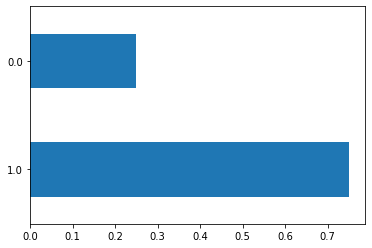

In [10]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
plot_counts(df_synthetic, 'sens_feat')

1.0
0.0


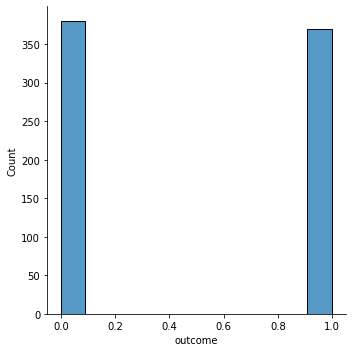

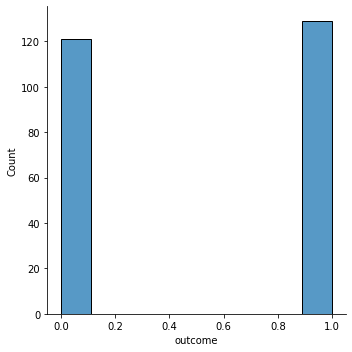

In [11]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
group_by_plot(df_synthetic, 'sens_feat', 'outcome')

# Preparation

### Train/Test Split

NOTES: 
1. Whether you input your own data, choose one of our provided datasets, or generate synthetic data, we will consider this to be the UNBIASED GROUND TRUTH.
2. Then, we will split the data, with the first part being the data which we will inject bias into and the second part being the unbiased ground truth testing data.



In [12]:
'''
    train_ratio: is the proportion of data examples in the training set
        (1-train_ratio is proportion in unbiased testing set)
'''
def train_test_split(df, train_ratio = 0.5):
    
    df_train = df.loc[range(0,int(len(df_synthetic)*train_ratio)), :]
    df_test = df_synthetic.loc[range(int(len(df_synthetic)*train_ratio)+1, len(df_synthetic)), :]
    
    return df_train, df_test

df_train, df_test = train_test_split(df_synthetic)

### Data Preprocessing

In [13]:
'''

This function separates the minority and majority classes

Parameters:
    
    sens_attr: sensitive attribute
    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class

'''
def get_maj_min(df, sens_attr, maj_val, min_val):
    assert sens_attr in list(df.columns), "Sensitive attribute must be a column in the dataframe!"
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    return df_majority, df_minority

df_majority, df_minority = get_maj_min(df_train, 'sens_feat', 1, 0)

#### One-Hot Encoding (ONLY for non-synthetic data)

In [14]:
# OHE categorical features (prompt for user's choice here?)

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

# df_train = pd.get_dummies(df_train, get_cat_cols(datasets['short_name']))

#### Formatting Data

In [15]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

In [16]:
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

sens_attrs_true = [df_test[datasets['synthetic'].sens_attr]]

# Bias Injection

### List of Biases
1. Representation
2. Measurement
3. Omitted Variable
4. Label Noise
5. Over-Sampling (of Majority)
6. Under-Sampling (of Minority)

NOTE: if data is NOT synthetic, print out the dataframe to check the dummy variables, e.g. if you want to apply a bias to a categorical feature cat_feat with value x, then use `df[cat_feat_x] == 1`

#### Representation Bias

Under-sample an attribute conditioned on subgroups for that feature and/or subgroups for other feature(s)

Note: you will need to input $\beta$, which is the probability of deleting an example from the desired group.

In [17]:
from biases import representation

#### Measurement Bias

Add noise to an attribute, either entirely or on various subgroups

Refer to [numpy.random documentation](https://numpy.org/doc/1.16/reference/routines.random.html) for types of sampling distributions for the noise.

Helper Functions:
1. Get unique values for categorical features
2. Get 5 number summary for numerical features

In [18]:
from biases import measurement, get_unique_cat, get_summary_num

#### Omitted Variable

Note: if you choose to remove the sensitive feature, you will no longer be able to impose a fairness intervention! Resulting comparisons will simply be between regular ml models trained with and without the sensitive attribute.

In [19]:
from biases import omitted_variable

#### Label Noise Bias

add noise to labels for a specific subset of the data (conditioned on another feature or subgroup of another feature)

In [20]:
from biases import label_noise

#### Over-Sampling Majority Class

Note: you can either choose to randomly over-sample existing examples or generate new samples by interpolation using SMOTE and ADASYN

In [21]:
from biases import random_over_sampling, over_sampling

#### Under-Sampling Minority Class

Note 1: you will need to input $\beta$, which is the probability of deleting an example from the minority class. For example, if $\beta = 0.25$ then each example in the training data will be deleted with probability $0.25$, which will result in approximately $25\%$ of the total minority class examples being deleted.

Note 2: this method is equivalent to using representation bias on the minority

In [22]:
from biases import under_sampling

### Bias Selection

In [23]:
biases = dict()

def add_bias(bias_func, short_name):
    biases[short_name] = bias_func

# example usage
add_bias(under_sampling, 'under_sampling')
add_bias(omitted_variable, 'omitted_variable')
add_bias(random_over_sampling, 'random_over_sampling')
add_bias(over_sampling, 'over_sampling')
add_bias(label_noise, 'label_noise')
add_bias(measurement, 'measurement')
add_bias(representation, 'representation')

### Bias Injection

In [24]:
#df_bias = biases['under_sampling'](df_train, 0.5, 'sens_feat', 1, 0)
#df_bias = biases['omitted_variable'](datasets, df_train, 'synthetic', 'num1', is_sens_attr=False)
#df_bias = biases['random_over_sampling'](df_train, 'sens_feat', 1, 0, 2)
#df_bias = biases['over_sampling'](df_train, df_minority, 'sens_feat', 1, 0, 2, type=2)
#df_bias = biases['label_noise'](df_train, 'sens_feat', 'categorical', 1, 0.2)
#df_bias = biases['measurement'](df_train, 'cat2', 'categorical', noise_prob=1, noise_type=1, subgroups=[2])
df_bias = biases['representation'](df_train, (df_train['num1'] > 0) & (df_train['cat1'] == 0), 0.5)

# for fairness measures later
if datasets['synthetic'].has_sens_attr:
    df_sens = df_bias[datasets['synthetic'].sens_attr]

# format data
X_bias = df_bias.iloc[:, :-1].values
y_bias = df_bias.iloc[:, -1].values

# Model

### Model Selection + Training (TODO: modularize)

In [25]:
# modularize and add data struct of different ml techniques

classifier = LogisticRegression(random_state = 42)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

sens_feat_true = df_test['sens_feat']
sens_feat_bias = df_sens

### Model Performance (TODO: modularize)

In [26]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Accuracy of Ground Truth Model on Ground Truth Data:  0.7034068136272545
Accuracy of Biased Model on Biased Data:  0.7334851936218679
Accuracy of Biased Model on Ground Truth Data:  0.6833667334669339


In [27]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(metrics=accuracy_score,y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.7034068136272545
Group Accuracy :  sens_feat
0.0    0.688525
1.0    0.708223
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.5070140280561122
Group Selection Rate :  sens_feat
0.0    0.590164
1.0    0.480106
Name: selection_rate, dtype: object


# Fairness Intervention

In [ ]:
# preprocessing

from fairlearn.preprocessing import CorrelationRemover

remover = CorrelationRemover(sensitive_feature_ids=[5])
remover_df = CorrelationRemover(sensitive_feature_ids=['sens_feat'])

X_train_corr = remover.fit_transform(X_train)
df_corr = pd.DataFrame(remover_df.fit_transform(df_train))

df_temp = df_train.drop('sens_feat', axis=1)
df_corr.columns = df_temp.columns

In [ ]:
constraints = [EqualizedOdds(), DemographicParity(), ErrorRateParity(),
               FalsePositiveRateParity(), TruePositiveRateParity()]

In [ ]:
# Exponentiated Gradient
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias, y_bias, sensitive_features = sens_feat_bias)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

In [ ]:
# Grid Search
constraint = DemographicParity()
mitigator_grid_bias = GridSearch(classifier_bias, constraint)
mitigator_grid_bias.fit(X_bias, y_bias, sensitive_features = sens_feat_bias)
y_pred_mitigated_grid_bias_on_true = mitigator_grid_bias.predict(X_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_grid_bias_on_true, y_true))

In [ ]:
# postprocessing

from fairlearn.postprocessing import ThresholdOptimizer

thresh_optim = ThresholdOptimizer(estimator=classifier_bias, constraints= 'equalized_odds', predict_method='auto')
thresh_optim.fit(X_bias, y_bias, sensitive_features=sens_feat_bias)
y_pred_thresh_on_true = thresh_optim.predict(X_true, sensitive_features=sens_feat_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_thresh_on_true, y_true))

# Evaluation

In [ ]:
print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

In [ ]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

# Trade-Off Visualization (Standalone)

In [ ]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(bias_amts, classifier, X_true, y_true, 
                           df_train, sensitive_feature = "cat",
                           is_synthetic = False,
                           apply_fairness = False, verbose = False):
    
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    count = 0

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    for bias in bias_amts:
        
        df_train_copy = df_train.copy()
        
        df_bias = biases['over_sampling'](df_train, df_minority, 'sens_feat', 1, 0, 2, type=2)
        df_sens = df_bias[sensitive_feature]

        # format data
        X_bias = df_bias.iloc[:, :-1].values
        y_bias = df_bias.iloc[:, -1].values
        
        if not is_synthetic:
            # OHE
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
            X_bias_true = np.array(ct.fit_transform(X_bias))
        else:
            X_bias_true = X_bias
        
        y_bias_true = df_bias.iloc[:, -1].values
        
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = DemographicParity()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [ ]:
def accuracy_visualizations(bias_amts,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()

In [ ]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated):
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Amount of Bias (number of minority samples removed)")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend()
    plt.show()

In [ ]:
classifier = LogisticRegression()

bias_amts = np.divide(list(range(10,-1,-1)),10)

bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(bias_amts, classifier, X_true, y_true,
                       df_train, "sens_feat", is_synthetic=True,
                       apply_fairness=True, verbose=True)

In [ ]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                     accuracy_on_biased_mitigated, accuracy_on_true_mitigated)

# Trade-Off Visualization (Error Bars)

In [ ]:
# ERROR BAR
def tradeoff_visualization_error(bias_amts, classifier, X_true, y_true, 
                           df_train, sensitive_feature = "cat",
                           is_synthetic = False,
                           apply_fairness = False, verbose = False, num_iters = 1):
    total_accuracy_on_true = []
    total_accuracy_on_biased = []
    total_accuracy_on_true_mitigated = []
    total_accuracy_on_biased_mitigated = []
    
    for i in range(num_iters):
        _, acc_bias, acc_true, acc_bias_mit, acc_true_mit = \
        tradeoff_visualization(bias_amts, classifier, X_true, y_true,
                               df_train, sensitive_feature,is_synthetic,
                               apply_fairness, verbose)
                
        total_accuracy_on_biased.append(acc_bias)
        total_accuracy_on_biased_mitigated.append(acc_bias_mit)
        total_accuracy_on_true.append(acc_true)
        total_accuracy_on_true_mitigated.append(acc_true_mit)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)

    mean_biased = np.mean(total_accuracy_on_biased, axis = 0)
    mean_biased_mitigated = np.mean(total_accuracy_on_biased_mitigated, axis = 0)
    mean_true = np.mean(total_accuracy_on_true, axis = 0)
    mean_true_mitigated = np.mean(total_accuracy_on_true_mitigated, axis = 0)

    y_err_biased = np.std(total_accuracy_on_biased, axis = 0)
    y_err_biased_mitigated = np.std(total_accuracy_on_biased_mitigated, axis = 0)
    y_err_true = np.std(total_accuracy_on_true, axis = 0)
    y_err_true_mitigated = np.std(total_accuracy_on_true_mitigated, axis = 0)

    return bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated

In [ ]:
def total_visualizations_error(bias_amts, mean_biased, mean_true,
                        mean_biased_mitigated, mean_true_mitigated):
    plt.figure(figsize=(10,7))
    plt.errorbar(bias_amts, mean_biased, yerr= y_err_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.errorbar(bias_amts, mean_biased_mitigated, yerr= y_err_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.errorbar(bias_amts, mean_true, yerr= y_err_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.errorbar(bias_amts, mean_true_mitigated, yerr= y_err_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    #plt.plot(bias_amts, bayes_accuracy_on_biased, label = 'Bayes Optimal Model On Biased Data', color = "black")
    #plt.axhline(y = bayes_optimal_accuracy(df_test), label = "Bayes Optimal Model On Ground Truth Data", color = "pink")
    plt.xlim(1.05, -0.05)
    plt.xlabel("Beta Value")
    plt.ylabel("Accuracy Score")
    plt.title("Accuracy of Biased Model (trained on biased data)")
    #plt.legend(loc = 1)
    plt.legend()
    plt.show()

In [ ]:
classifier = LogisticRegression()

bias_amts = np.divide(list(range(10,-1,-1)),10)

bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated = \
tradeoff_visualization_error(bias_amts, classifier, X_true, y_true,
                       df_train, "sens_feat", is_synthetic=True,
                       apply_fairness=True, verbose=True, num_iters=2)

In [ ]:
total_visualizations_error(bias_amts, mean_biased, mean_true,
                    mean_biased_mitigated, mean_true_mitigated)